# Automated Car Image Scraping, Validation, and Dataset Preparation Workflow

This notebook provides a streamlined workflow for building a high-quality car image dataset, ready for machine learning tasks. The process is fully automated and includes the following steps:

---

**1. Automated Scraping**  
Collect car images from multiple online sources with non-duplicate URLs.

- **Current Sources:**  
    - Google Images  
    - Carmudi  
    - Mobil123  

---

**2. Image Validation & Cropping**  
Checks each image for quality and consistency, cropping them as needed to standardize the dataset.

---

**3. Dataset Splitting**  
Organizes validated images into training, validation, and test sets for machine learning workflows.

---

**4. Comprehensive Reporting**  
Generates visual and tabular reports on:

- Scraping performance  
- Validation status  
- Class distribution  

---

This workflow ensures you have a clean, well-organized, and well-documented car image dataset.

In [1]:
# Install playwright for Browser scraping

!playwright install

In [2]:
# Define constants based on the configuration file

import json
import os

DATA_PROCESSING_DIRECTORY = './data_processing'
BASE_DIRECTORY = os.path.join(DATA_PROCESSING_DIRECTORY, "scraping")
CONFIG_PATH = os.path.join(BASE_DIRECTORY, "config.json")


OUTPUT_DIRECTORY = os.path.join(DATA_PROCESSING_DIRECTORY, "data")
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

REPORTS_DIRECTORY = os.path.join(OUTPUT_DIRECTORY, "reports")
os.makedirs(REPORTS_DIRECTORY, exist_ok=True)

IMAGES_DIRECTORY = os.path.join(OUTPUT_DIRECTORY, "images")
os.makedirs(IMAGES_DIRECTORY, exist_ok=True)

MASTER_CSV_PATH = os.path.join(REPORTS_DIRECTORY, "google_image_scraper_results.csv")
SUMMARY_CSV_PATH = os.path.join(REPORTS_DIRECTORY, "scrape_summary_report.csv")

with open(CONFIG_PATH, "r") as config_file:
    config = json.load(config_file)

print("⚙️ Configuration loaded. Ready to run the scraper in the next cell.")

⚙️ Configuration loaded. Ready to run the scraper in the next cell.


In [3]:
# Run the scraper

from data_processing.scraping.master_scraper import MasterScraper


print("Starting the scraping and downloading process...")
scraper = MasterScraper(
    config_path=CONFIG_PATH,
    images_dir=IMAGES_DIRECTORY,
    csv_path=MASTER_CSV_PATH,
    summary_csv_path=SUMMARY_CSV_PATH,
)
await scraper.run()

print("\n✅ Scraping and downloading process finished!")

Starting the scraping and downloading process...


Scraping All Sources: 100%|██████████| 261/261 [18:09<00:00,  4.18s/it] 



✅ Scraping and downloading process finished!


In [4]:
# Validate and crop images

from data_processing.scraping.dataset_validator import DatasetValidator

REJECTED_DIR = os.path.join(OUTPUT_DIRECTORY, "rejected_images")
os.makedirs(REJECTED_DIR, exist_ok=True)

print("Starting dataset validation...")
validator = DatasetValidator(
    master_csv_path=MASTER_CSV_PATH,
    rejected_dir=REJECTED_DIR,
)
validator.validate_and_crop_images()

print("\n✅ Validation and cropping process finished!")

Starting dataset validation...
YOLOv12 object detection model loaded.
Found 21364 downloaded images to validate and crop.


Validating & Cropping Images:   0%|          | 0/21364 [00:00<?, ?it/s]

Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)
Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)
Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)
Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)
Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)


2025-06-21 23:53:43,365 - ERROR - Could not process ./data_processing/scraping/data/images/sedan/sedan_-1995737445222466043.jpg: 'Conv' object has no attribute 'bn'
2025-06-21 23:53:43,367 - ERROR - Could not process ./data_processing/scraping/data/images/sedan/sedan_-1577150884979188204.jpg: 'Conv' object has no attribute 'bn'
2025-06-21 23:53:43,368 - ERROR - Could not process ./data_processing/scraping/data/images/sedan/sedan_5436531880722067465.jpg: 'Conv' object has no attribute 'bn'
2025-06-21 23:53:43,367 - ERROR - Could not process ./data_processing/scraping/data/images/sedan/sedan_-1577150884979188204.jpg: 'Conv' object has no attribute 'bn'
2025-06-21 23:53:43,368 - ERROR - Could not process ./data_processing/scraping/data/images/sedan/sedan_5436531880722067465.jpg: 'Conv' object has no attribute 'bn'


Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)


Validating & Cropping Images:   0%|          | 4/21364 [00:00<11:44, 30.32it/s]

Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)


2025-06-21 23:53:43,377 - ERROR - Could not process ./data_processing/scraping/data/images/sedan/sedan_4933371416826464774.jpg: 'Conv' object has no attribute 'bn'


Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)
Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)
Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)
Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)
Ultralytics 8.3.156 🚀 Python-3.12.2 torch-2.7.1 CPU (Apple M2)
YOLOv12m summary (fused): 169 layers, 20,166,592 parameters, 0 gradients, 67.5 GFLOPs
YOLOv12m summary (fused): 169 layers, 20,166,592 parameters, 0 gradients, 67.5 GFLOPs
YOLOv12m summary (fused): 169 layers, 20,166,592 parameters, 0 gradients, 67.5 GFLOPs
YOLOv12m summary (fused): 169 layers, 20,166,592 parameters, 0 gradients, 67.5 GFLOPs
YOLOv12m summary (fused): 169 layers, 20,166,592 parameters, 0 gradients, 67.5 GFLOPs
YOLOv12m summary (fused): 169 layers, 20,166,592 parameters, 0 gradients, 67.5 GFLOPs
YOLOv12m summary (fused): 169 layers, 20,166,592 parameters, 0 gradients, 67.5 GFLOPs
YOLOv12m summary (fused): 169 layers, 20,166,592 parameters, 0 gradients, 67.5 GFLO

Validating & Cropping Images: 100%|██████████| 21364/21364 [1:26:04<00:00,  4.14it/s]  


Validation complete. Report saved to ./data_processing/scraping/data/reports/google_image_scraper_results.csv

✅ Validation and cropping process finished!


In [ ]:
# Split the dataset into training, validation, and test sets

import os

from data_processing.scraping.create_dataset_split import DatasetSplitter

print("Starting Dataset Splitting")

FINAL_DATASET_DIR = os.path.join(OUTPUT_DIRECTORY, "dataset")

splitter = DatasetSplitter(
    source_dir=IMAGES_DIRECTORY,
    output_dir=FINAL_DATASET_DIR,
)
splitter.split_and_copy()

print("\n✅ Dataset splitting process finished!")

Starting Dataset Splitting


Copying test files: 100%|██████████| 1673/1673 [00:00<00:00, 1942.49it/s]


Total images in source: 16729
--------------------
Training set: 13383 images
Validation set: 1673 images
Test set: 1673 images
Total split: 16729 images

✅ Dataset splitting process finished!



PART 1: SCRAPING PERFORMANCE REPORT (UNIQUES vs. DUPLICATES)
Unique URLs Found vs. Duplicates Skipped per Source:


,Source,unique_found,duplicates_skipped
0,Google,13978,5141
1,Mobil123,3945,251
2,Carmudi,3506,186


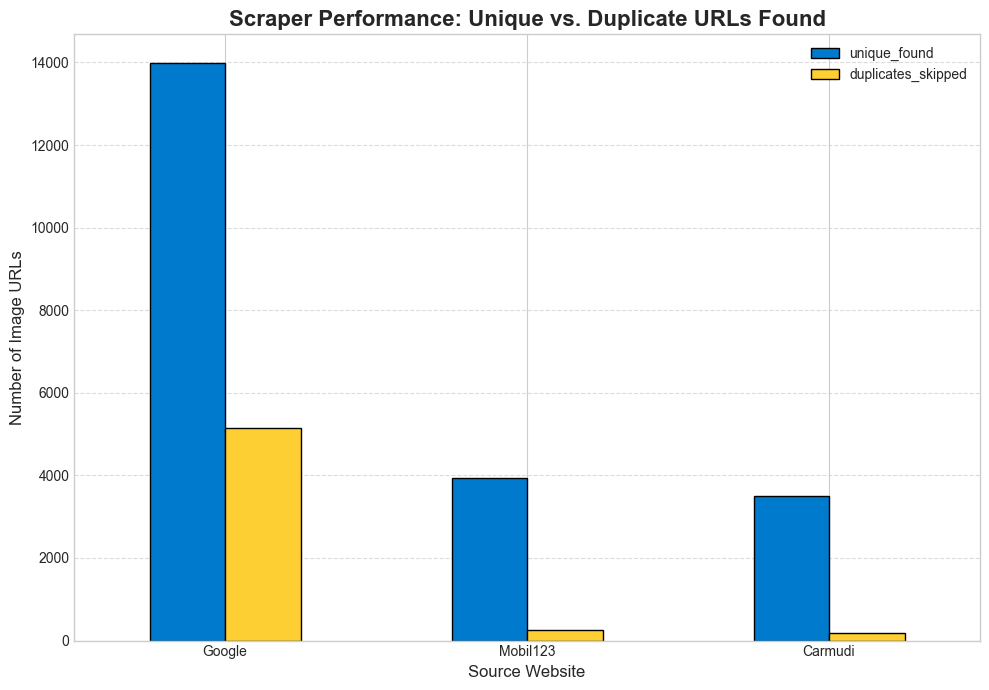


PART 2: VALIDATION & FINAL DATASET REPORT

--- 2a. Overall Validation Status ---


validation_status
valid_and_cropped            16729
rejected_low_resolution       4235
rejected_not_a_car             396
rejected_processing_error        4
Name: count, dtype: int64

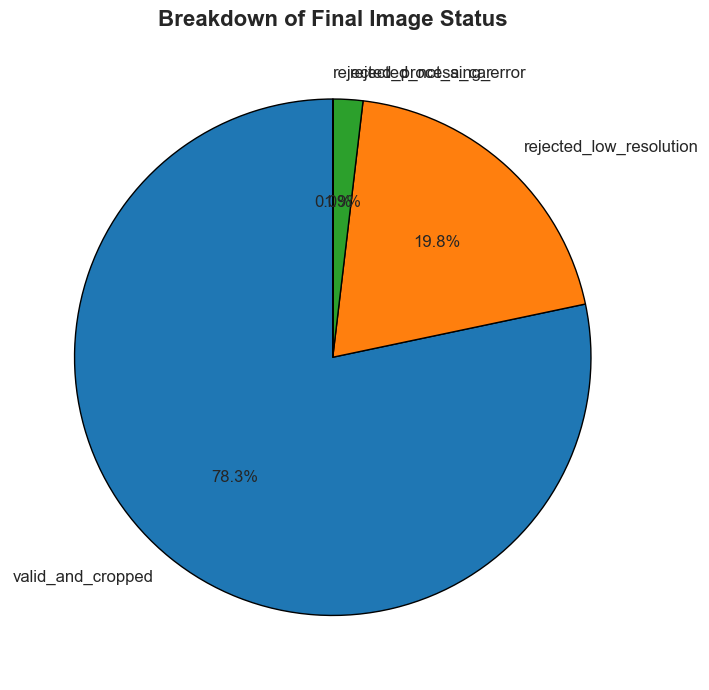


--- 2b. Final Class Distribution ---


class
suv          3980
mpv          3261
sedan        3036
hatchback    2401
pickup       1299
van          1119
offroad      1115
truck         518
Name: count, dtype: int64

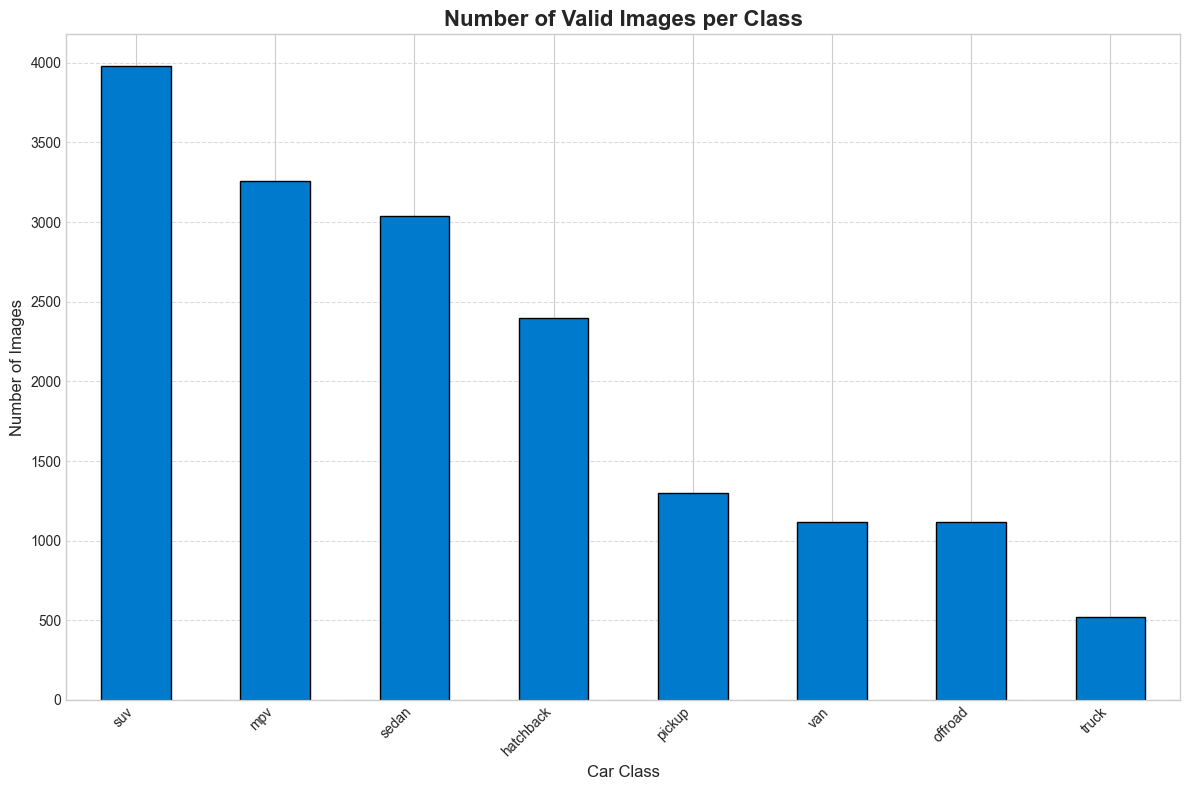

In [6]:
# Generate reports for scraping performance and validation results

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os


def load_all_data(config_file="config.json"):
    """Loads config and all necessary report CSVs."""
    summary_df, master_df = None, None
    try:

        if os.path.exists(SUMMARY_CSV_PATH):
            summary_df = pd.read_csv(SUMMARY_CSV_PATH)
        else:
            print(
                f"❌ Scrape summary file not found at {SUMMARY_CSV_PATH}. Please run Cell 2."
            )

        if os.path.exists(MASTER_CSV_PATH):
            master_df = pd.read_csv(MASTER_CSV_PATH)
        else:
            print(
                f"❌ Master data file not found at {MASTER_CSV_PATH}. Please run Cell 3."
            )

        return summary_df, master_df
    except FileNotFoundError:
        print(f"❌ {config_file} not found. Please run Cell 1 to create it.")
        return None, None, None


def plot_scraping_performance(df, reports_path):
    """Generates and displays a bar chart for unique vs. duplicate URLs."""
    print("\n" + "=" * 80)
    print("PART 1: SCRAPING PERFORMANCE REPORT (UNIQUES vs. DUPLICATES)")
    print("=" * 80)
    print("Unique URLs Found vs. Duplicates Skipped per Source:")
    display(df)

    df.plot(
        x="Source",
        y=["unique_found", "duplicates_skipped"],
        kind="bar",
        figsize=(10, 7),
        color=["#007ACC", "#FDCF33"],
        edgecolor="black",
    )
    plt.title(
        "Scraper Performance: Unique vs. Duplicate URLs Found",
        fontsize=16,
        weight="bold",
    )
    plt.ylabel("Number of Image URLs", fontsize=12)
    plt.xlabel("Source Website", fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(reports_path, "chart_scraping_performance.png"))
    plt.show()


def plot_validation_pie_chart(df, reports_path):
    """Generates a pie chart of the overall validation status."""
    print("\n--- 2a. Overall Validation Status ---")
    status_counts = df["validation_status"].value_counts()
    display(status_counts)

    plt.figure(figsize=(10, 7))
    status_counts.plot.pie(
        autopct="%1.1f%%",
        startangle=90,
        wedgeprops={"edgecolor": "black", "linewidth": 1},
        textprops={"fontsize": 12},
    )
    plt.title("Breakdown of Final Image Status", fontsize=16, weight="bold")
    plt.ylabel("")
    plt.tight_layout()
    plt.savefig(os.path.join(reports_path, "chart_validation_status.png"))
    plt.show()


def plot_class_distribution_chart(df, reports_path):
    """Generates a bar chart showing the number of valid images per class."""
    print("\n--- 2b. Final Class Distribution ---")
    class_counts = df["class"].value_counts()
    display(class_counts)

    plt.figure(figsize=(12, 8))
    class_counts.plot(kind="bar", color="#007ACC", edgecolor="black")
    plt.title("Number of Valid Images per Class", fontsize=16, weight="bold")
    plt.ylabel("Number of Images", fontsize=12)
    plt.xlabel("Car Class", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(reports_path, "chart_class_distribution.png"))
    plt.show()


def generate_all_reports():
    """
    Main function to orchestrate the entire reporting process, including
    scraping performance and validation results.
    """
    plt.style.use("seaborn-v0_8-whitegrid")

    summary_df, master_df = load_all_data()

    if summary_df is not None:
        plot_scraping_performance(summary_df, REPORTS_DIRECTORY)

    if master_df is not None and "validation_status" in master_df.columns:
        print("\n" + "=" * 80)
        print("PART 2: VALIDATION & FINAL DATASET REPORT")
        print("=" * 80)

        valid_images_df = master_df[
            master_df["validation_status"] == "valid_and_cropped"
        ].copy()

        plot_validation_pie_chart(master_df, REPORTS_DIRECTORY)

        if not valid_images_df.empty:
            plot_class_distribution_chart(valid_images_df, REPORTS_DIRECTORY)
        else:
            print("\nNo valid images found to generate final dataset reports.")
    else:
        print("\nSkipping validation reports because data file was not found or not validated.")


generate_all_reports()